NLP Project
---
Coronavirus Tweets NLP - Text Classification

In [40]:
# requirements and data preparation
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import warnings

from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings('ignore')

training = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')
test = pd.read_csv('Corona_NLP_test.csv', encoding='latin-1')

training_data = training[['OriginalTweet', 'Sentiment']]
test_data = test[['OriginalTweet', 'Sentiment']]

In [41]:
# preprocessing
def format_data(text):
    text = str(text).strip()
    text = text.lower()
    text = re.sub(r"http\S+","",text)
    text = re.sub(r"@\w+","",text)
    text = re.sub(r"#\w+","",text)
    text = re.sub(r"\d+","",text)
    text = re.sub(r"<.*?>","",text)
    text = text.split()
    stop_words = stopwords.words('english')
    text = ' '.join([word for word in text if not word in stop_words])
    return text

training_data['OriginalTweet'] = training_data['OriginalTweet'].apply(lambda x: format_data(x))
training_data['OriginalTweet'] = training_data['OriginalTweet'].replace('', np.nan)
training_data = training_data.dropna(subset=['OriginalTweet'])
training_data['Sentiment'] = training_data['Sentiment'].replace({'Extremely Positive': 2, 'Positive': 1, 'Neutral': 0,
                                                                 'Negative': -1, 'Extremely Negative': -2})
# training_data['Sentiment'] = pd.factorize(training_data['Sentiment'])[0].astype(int)
print(training_data.head(10))

data_train, data_test = train_test_split(training_data, test_size=0.3)
x_train = data_train[['OriginalTweet']]
y_train = data_train[['Sentiment']]
x_test = data_test[['OriginalTweet']]
y_test = data_test[['Sentiment']]

                                        OriginalTweet  Sentiment
1   advice talk neighbours family exchange phone n...          1
2   coronavirus australia: woolworths give elderly...          1
3   food stock one empty... please, panic, enough ...          1
4   me, ready go supermarket outbreak. i'm paranoi...         -2
5   news regionâs first confirmed covid- case cam...          1
6   cashier grocery store sharing insights prove c...          1
7                supermarket today. buy toilet paper.          0
8   due covid- retail store classroom atlanta open...          1
9   corona prevention,we stop buy things cash use ...         -1
10  month crowding supermarkets restaurants, howev...          0


In [43]:
# training
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train['OriginalTweet'])
x_train_new = tokenizer.texts_to_sequences(x_train['OriginalTweet'])
x_test_new = tokenizer.texts_to_sequences(x_test['OriginalTweet'])

max_len = np.max(training_data['OriginalTweet'].apply(lambda x: len(x)))
x_train_new = pad_sequences(x_train_new, maxlen=max_len, padding='post')
x_test_new = pad_sequences(x_test_new, maxlen=max_len, padding='post')

embedding_dim = 25
vocab_len = len(tokenizer.word_index) + 1
model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_len, embedding_dim, input_length=max_len),
                            tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
                            tf.keras.layers.GlobalAveragePooling1D(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(16, activation = 'relu', activity_regularizer=tf.keras.regularizers.L2(0.01)),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(5, activation = 'softmax')])
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

y_train_new = to_categorical(y_train, 5)
y_test_new = to_categorical(y_test, 5)

num_epochs = 20
history = model.fit(x_train_new, y_train_new, epochs=num_epochs, validation_data=(x_test_new, y_test_new))

Epoch 1/20
900/900 [==============================] - 63s 68ms/step - loss: 1.5821 - accuracy: 0.2740 - val_loss: 1.5276 - val_accuracy: 0.2983
Epoch 2/20
900/900 [==============================] - 61s 67ms/step - loss: 1.3867 - accuracy: 0.3866 - val_loss: 1.1071 - val_accuracy: 0.5476
Epoch 3/20
900/900 [==============================] - 61s 68ms/step - loss: 1.0146 - accuracy: 0.6111 - val_loss: 0.8754 - val_accuracy: 0.7222
Epoch 4/20
900/900 [==============================] - 62s 69ms/step - loss: 0.8131 - accuracy: 0.7262 - val_loss: 0.7772 - val_accuracy: 0.7464
Epoch 5/20
900/900 [==============================] - 61s 68ms/step - loss: 0.6942 - accuracy: 0.7780 - val_loss: 0.7543 - val_accuracy: 0.7462
Epoch 6/20
900/900 [==============================] - 61s 68ms/step - loss: 0.6058 - accuracy: 0.8155 - val_loss: 0.7578 - val_accuracy: 0.7556
Epoch 7/20
900/900 [==============================] - 62s 69ms/step - loss: 0.5397 - accuracy: 0.8376 - val_loss: 0.7887 - val_accuracy:

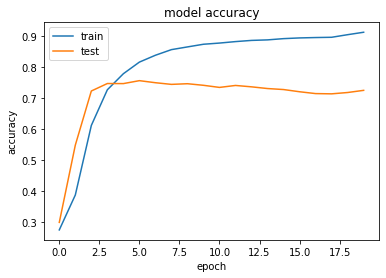

In [44]:
# evaluate
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()